# Face Recognition
- Face recognition with LBPH and OpenCV
- Face recognition with Dlib, CNN and distance calculation


### LBPH (LOCAL BINARY PATTERNS HISTOGRAMS)
LBPH(Local Binary Patterns Histograms)은 이미지에서 지역적인 이진 패턴을 추출하여 각 픽셀의 주변 텍스처와 패턴을 특징화하는 알고리즘이다.
중앙값 픽셀을 기준으로 크거나 같으면 1 작으면 0으로 표현하고 중앙값을 제외 후 1 또는 0을 이어주면 이진수가 나타나는데 이것이 해당 픽셀이 나타내고 있는 특징으로 볼 수 있다. 이러한 이진수는 밝기를 조절할때 강력하고 각각의 이진수 패턴을 히스토그램으로 통계적으로 표현할 수 있다. 이런 히스토그램을 가지고 있는 한 픽셀을 학습한 데이터의 히스토그램과 비교하여 얼굴을 인식할 수 있다.

### Loading the dataset
- 앞으로 사용할 데이터셋의 출처 = Yale faces database
  - url: http://vision.ucsd.edu/content/yale-face-database


In [1]:
#PIL(Pillow) 이미지 처리 라이브러리(gif이미지, 간단한 이미지 작업)
from PIL import Image
import cv2 # 이미지 처리 라이브러리(컴퓨터 비전 처리)
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# zip 압축 파일을 추출할 라이브러리
import zipfile
path = '/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Datasets/yalefaces.zip'
# mode는 읽기, 쓰기, 읽고쓰기 중 어떤 작업을 할지 정하는것이다. r을 read이다.
zip_object =zipfile.ZipFile(file = path, mode = 'r')
# 현재위치에서 파일을 생성해라
zip_object.extractall('./')
zip_object.close()

### Pre-processing the images( 데이터 전처리 )
- 준비한 데이터셋을 얼굴인식 알고리즘에서 사용할 수 있도록 알맞은 형태로 전처리하는 과정


In [6]:
import os
# os.listdir()는 매개변수안에 있는 파일들을 다 보여준다
print(os.listdir('/content/yalefaces/train'))

['subject11.sleepy.gif', 'subject06.surprised.gif', 'subject04.rightlight.gif', 'subject06.sad.gif', 'subject08.sad.gif', 'subject02.sad.gif', 'subject09.noglasses.gif', 'subject13.noglasses.gif', 'subject06.rightlight.gif', 'subject03.rightlight.gif', 'subject06.glasses.gif', 'subject12.sad.gif', 'subject07.sleepy.gif', 'subject02.normal.gif', 'subject09.normal.gif', 'subject05.centerlight.gif', 'subject12.surprised.gif', 'subject04.sleepy.gif', 'subject04.happy.gif', 'subject08.centerlight.gif', 'subject06.wink.gif', 'subject06.sleepy.gif', 'subject12.happy.gif', 'subject11.noglasses.gif', 'subject07.noglasses.gif', 'subject12.noglasses.gif', 'subject08.surprised.gif', 'subject15.normal.gif', 'subject11.centerlight.gif', 'subject09.surprised.gif', 'subject15.sleepy.gif', 'subject08.happy.gif', 'subject01.sleepy.gif', 'subject15.leftlight.gif', 'subject03.normal.gif', 'subject11.sad.gif', 'subject14.centerlight.gif', 'subject14.rightlight.gif', 'subject09.sleepy.gif', 'subject05.nogla

In [25]:
# 이미지를 가져온 다음 본 알고리즘에 맞는 형식으로 전송하는 함수
def get_image_data():
  paths=[os.path.join('/content/yalefaces/train',f) for f in os.listdir('/content/yalefaces/train')]
  print(paths)
  # 불러온 이미지 저장
  faces = []
  # 이미지의 객체 대상 저장
  ids = []
  for path in paths:
    # gif이미지를 가져와서 numpy로 변환, convert의 L mode는 단일 채널 이미지로 흑백 이미지이다.
    image = Image.open(path).convert('L')
    # PIL의 image 객체로 반환된 데이터를 opencv로 사용할려면 numpy로 변환해야된다.(unit8은 각 픽셀이 정수형 값을 갖는 이미지이다.)
    image_np = np. array(image, 'uint8')
    # 각각의 이미지의 객체 번호를 받아오는 작업
    id = int(os.path.split(path)[1].split('.')[0].replace('subject',''))
    ids.append(id)
    faces.append(image_np)
  return np.array(ids), faces


In [26]:
ids, faces = get_image_data()

['/content/yalefaces/train/subject11.sleepy.gif', '/content/yalefaces/train/subject06.surprised.gif', '/content/yalefaces/train/subject04.rightlight.gif', '/content/yalefaces/train/subject06.sad.gif', '/content/yalefaces/train/subject08.sad.gif', '/content/yalefaces/train/subject02.sad.gif', '/content/yalefaces/train/subject09.noglasses.gif', '/content/yalefaces/train/subject13.noglasses.gif', '/content/yalefaces/train/subject06.rightlight.gif', '/content/yalefaces/train/subject03.rightlight.gif', '/content/yalefaces/train/subject06.glasses.gif', '/content/yalefaces/train/subject12.sad.gif', '/content/yalefaces/train/subject07.sleepy.gif', '/content/yalefaces/train/subject02.normal.gif', '/content/yalefaces/train/subject09.normal.gif', '/content/yalefaces/train/subject05.centerlight.gif', '/content/yalefaces/train/subject12.surprised.gif', '/content/yalefaces/train/subject04.sleepy.gif', '/content/yalefaces/train/subject04.happy.gif', '/content/yalefaces/train/subject08.centerlight.gif

### Model Training( 모델 학습 )
- 전처리된 데이터를 활용하여 모델을 학습하는 과정


In [27]:
# gridx와 gridy는 이미지안에서 히스토그램을 만들 구역 x, y 길이를 설정한다. 기본값은 8*8의 히스토그램을 갖는다.
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.train(faces, ids)
# 분류기를 저장할때 확장자는 기본적으로 yml이다.
lbph_classifier.write('lbph_classifier.yml')

### model inference ( 모델 사용 )
- 학습이 완료된 모델을 이용하여 실제 사용할 데이터의 클래스를 분류하는 과정

In [28]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
# 이전에 생성한 모델을 생성한 객체에 저장
lbph_classifier.read('lbph_classifier.yml')

In [33]:
# test데이터도 모델에 사용할 수 있도록 전처리
test_image = '/content/yalefaces/test/subject05.sleepy.gif'
image = Image.open(test_image).convert('L')
image_np = np.array(image, 'uint8')
# 모델을 사용하여 분류(분류된 클레스, 신뢰도 - 높을수록좋음)
prediction = lbph_classifier.predict(image_np)
print(prediction)

(5, 7.936066004950048)


In [36]:
# 실제 정답 클래스 추출
expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject',''))

5

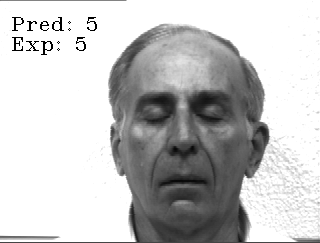

In [39]:
cv2.putText(image_np, 'Pred: '+ str(prediction[0]), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0)) # 예측
cv2.putText(image_np, 'Exp: '+ str(expected_output), (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0)) # 정답
cv2_imshow(image_np)

### Model Evaluation ( 모델 평가 )
- 학습이 완료된 모델을 이용하여 test 데이터를 사용하여 평가하는 작업


In [53]:
paths=[os.path.join('/content/yalefaces/test',f) for f in os.listdir('/content/yalefaces/test')]
predictions =[]
expected_outuputs =[]
for path in paths:
  image = Image.open(path).convert('L')
  image_np = np. array(image, 'uint8')
  prediction = lbph_classifier.predict(image_np)
  expected_outupt = int(os.path.split(path)[1].split('.')[0].replace('subject',''))
  predictions.append(prediction[0])
  expected_outuputs.append(expected_outupt)

In [54]:
expected_outuputs = np.array(expected_outuputs)
predictions = np.array(predictions)
print(predictions)
print(expected_outuputs)

[12  1  3  1  7 12  5  7 13 14  8  4  5  9  5 15  9 14 13  9  6  4  4 14
  7 11 11  4 10  9]
[12  1  3  1 15 12  5  9 13 14  8  2  5  9  2 15  4  6 13  7  6  4  8 14
  7 11 11 10 10  3]


In [55]:
# sklearn은 대표적인 머신러닝 라이브러리이다.
from sklearn.metrics import accuracy_score
# 정확도 측정
accuracy_score(expected_outuputs, predictions)

0.6666666666666666

##### 정확도 0.66666... 로 높지않다. 클래스가 전부 참이기도하고 오차행렬도 없어 정확도가 낮다.

In [56]:
# confusion_matrix 생성
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_outuputs, predictions)
cm

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]])

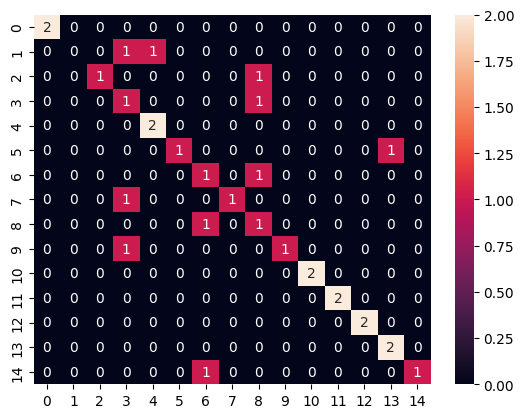

In [58]:
# 좀 더 보기 좋게 시각화
import seaborn
# annot속성은 표안에 수치를 글자로 표시할지 선택하는 속성이다.
# 열을 실제 정답 클래스, 행은 예측 클래스
# 대각선은 맞힌 횟수, 열 밖에 있는 숫자는 틀린횟수
seaborn.heatmap(cm, annot = True);